In [ ]:
!pip install gymnasium
!pip install torch torchvision
!pip install numpy matplotlib


In [ ]:
import gymnasium as gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt


In [ ]:
!pip install gymnasium[atari] ale-py


In [ ]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

In [ ]:
class DQNAgent:
    def __init__(self, state_dim, action_dim, lr=0.001, gamma=0.99, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.memory = deque(maxlen=10000)

        self.model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_dim)
        state = torch.FloatTensor(state.flatten()).unsqueeze(0)
        q_values = self.model(state)
        return torch.argmax(q_values).item()

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)

        states = torch.FloatTensor(np.array(states)).reshape(-1, self.state_dim)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(np.array(next_states)).reshape(-1, self.state_dim)
        dones = torch.FloatTensor(dones)

        current_q = self.model(states).gather(1, actions.unsqueeze(1))
        next_q = self.model(next_states).detach().max(1)[0]
        target_q = rewards + (1 - dones) * self.gamma * next_q

        loss = self.loss_fn(current_q.squeeze(), target_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

Episode: 0, Total Reward: -70, Epsilon: 1.00


<ipython-input-11-f8009a2a4ac0>:35: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  dones = torch.FloatTensor(dones)


Episode: 100, Total Reward: -3660, Epsilon: 0.01
Episode: 200, Total Reward: 30, Epsilon: 0.01
Episode: 300, Total Reward: 30, Epsilon: 0.01
Episode: 400, Total Reward: 30, Epsilon: 0.01
Episode: 500, Total Reward: 30, Epsilon: 0.01
Episode: 600, Total Reward: 30, Epsilon: 0.01
Episode: 700, Total Reward: 30, Epsilon: 0.01
Episode: 800, Total Reward: 30, Epsilon: 0.01
Episode: 900, Total Reward: 30, Epsilon: 0.01


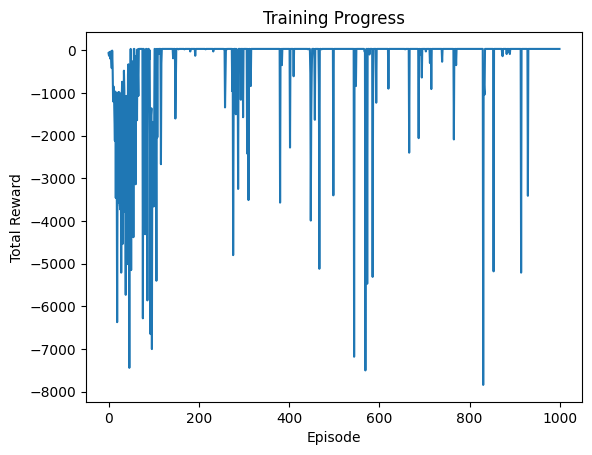

In [ ]:
env = TicTacToeEnv()
agent = DQNAgent(state_dim=9, action_dim=9)

episodes = 1000
batch_size = 32
scores = []

for episode in range(episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False

    while not done:
        action = agent.act(state)
        next_state, reward, done, _, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        if done:
            break

        agent.replay(batch_size)

    scores.append(total_reward)
    if episode % 100 == 0:
        print(f"Episode: {episode}, Total Reward: {total_reward}, Epsilon: {agent.epsilon:.2f}")

# Plot the scores
plt.plot(scores)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Progress")
plt.show()

In [ ]:
state, _ = env.reset()
done = False

while not done:
    action = agent.act(state)
    state, reward, done, _, _ = env.step(action)
    env.render()
    if done:
        print(f"Game Over! Reward: {reward}")
        break

[[0 0 0]
 [0 0 0]
 [0 0 1]]
[[ 0  0  0]
 [ 0  0  0]
 [-1  0  1]]
[[ 0  0  1]
 [ 0  0  0]
 [-1  0  1]]
[[ 0  0  1]
 [ 0  0  0]
 [-1 -1  1]]
[[ 0  0  1]
 [ 0  0  1]
 [-1 -1  1]]
Game Over! Reward: 30


In [ ]:
# Save the model
torch.save(agent.model.state_dict(), "tic_tac_toe_dqn.pth")

# Load the model
agent.model.load_state_dict(torch.load("tic_tac_toe_dqn.pth"))
agent.model.eval()

DQN(
  (fc): Sequential(
    (0): Linear(in_features=9, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=9, bias=True)
  )
)

In [ ]:
# Load the trained model
agent.model.load_state_dict(torch.load("tic_tac_toe_dqn.pth"))
agent.model.eval()  # Set the model to evaluation mode

DQN(
  (fc): Sequential(
    (0): Linear(in_features=9, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=9, bias=True)
  )
)

In [ ]:
def play_game(env, agent):
    state, _ = env.reset()
    done = False

    print("Game Start!")
    env.render()

    while not done:
        # Human Player's Turn
        print("\nYour turn! (Player -1)")
        valid_move = False
        while not valid_move:
            try:
                action = int(input("Enter your move (0-8): "))
                row, col = divmod(action, 3)
                if state[row, col] == 0:  # Check if the cell is empty
                    valid_move = True
                else:
                    print("Invalid move! Cell is already occupied.")
            except ValueError:
                print("Invalid input! Enter a number between 0 and 8.")

        # Apply the human player's move
        state, reward, done, _, _ = env.step(action)
        env.render()

        if done:
            if reward == -10:
                print("Game Over! You lost due to an invalid move.")
            elif reward == 10:
                print("Game Over! You won!")
            else:
                print("Game Over! It's a draw.")
            break

        # Agent's Turn
        print("\nAgent's turn! (Player 1)")
        action = agent.act(state)
        state, reward, done, _, _ = env.step(action)
        env.render()

        if done:
            if reward == -10:
                print("Game Over! The agent made an invalid move.")
            elif reward == 10:
                print("Game Over! The agent won!")
            else:
                print("Game Over! It's a draw.")
            break

def check_winner(self):
    # Check rows, columns, and diagonals
    for i in range(3):
        if abs(np.sum(self.board[i, :])) == 3:  # Row win
            return np.sum(self.board[i, :]) * 10
        if abs(np.sum(self.board[:, i])) == 3:  # Column win
            return np.sum(self.board[:, i]) * 10
    if abs(np.trace(self.board)) == 3:  # Main diagonal win
        return np.trace(self.board) * 10
    if abs(np.trace(np.fliplr(self.board))) == 3:  # Anti-diagonal win
        return np.trace(np.fliplr(self.board)) * 10
    return 0  # No winner yet

def check_winner(self):
    print(f"Board:\n{self.board}")
    for i in range(3):
        row_sum = np.sum(self.board[i, :])
        col_sum = np.sum(self.board[:, i])
        print(f"Row {i}: {row_sum}, Col {i}: {col_sum}")
        if abs(row_sum) == 3:
            print(f"Row win detected! Reward: {row_sum * 10}")
            return row_sum * 10
        if abs(col_sum) == 3:
            print(f"Column win detected! Reward: {col_sum * 10}")
            return col_sum * 10

    main_diag = np.trace(self.board)
    anti_diag = np.trace(np.fliplr(self.board))
    print(f"Main diagonal: {main_diag}, Anti-diagonal: {anti_diag}")
    if abs(main_diag) == 3:
        print(f"Main diagonal win detected! Reward: {main_diag * 10}")
        return main_diag * 10
    if abs(anti_diag) == 3:
        print(f"Anti-diagonal win detected! Reward: {anti_diag * 10}")
        return anti_diag * 10

    print("No winner yet.")
    return 0  # No winner yet

def step(self, action):
    row, col = divmod(action, 3)
    if self.board[row, col] != 0:
        print(f"Invalid move at ({row}, {col})")
        return self.board.copy(), -10, True, False, {}  # Invalid move penalty

    self.board[row, col] = self.current_player
    reward = self.check_winner()
    done = reward != 0 or np.all(self.board != 0)

    print(f"Board after move:\n{self.board}")
    print(f"Reward: {reward}, Done: {done}")

    self.current_player *= -1  # Switch player
    return self.board.copy(), reward, done, False, {}

In [ ]:
env = TicTacToeEnv()
play_game(env, agent)

Game Start!
[[0 0 0]
 [0 0 0]
 [0 0 0]]

Your turn! (Player -1)
Enter your move (0-8): 2
[[0 0 1]
 [0 0 0]
 [0 0 0]]

Agent's turn! (Player 1)
[[ 0  0  1]
 [ 0  0  0]
 [-1  0  0]]

Your turn! (Player -1)
Enter your move (0-8): 5
[[ 0  0  1]
 [ 0  0  1]
 [-1  0  0]]

Agent's turn! (Player 1)
[[ 0  0  1]
 [ 0  0  1]
 [-1 -1  0]]

Your turn! (Player -1)
Enter your move (0-8): 8
[[ 0  0  1]
 [ 0  0  1]
 [-1 -1  1]]
Game Over! It's a draw.
